In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from utils import plot, read_ucm_params_kalibr, initRectifyMap, equirectangular_projection, \
  rotate_cw_90, rotate_ccw_90, rotate_180

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 15]

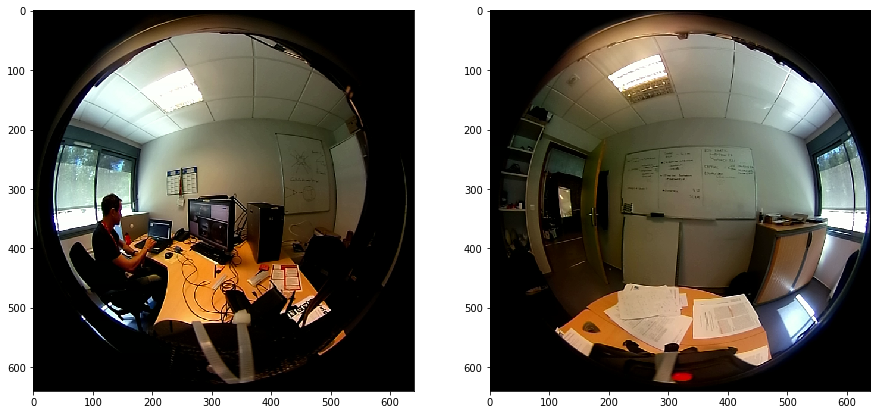

In [3]:
image_file = 'btm0000.png'
image = cv2.imread(image_file)
(rows,cols,channels) = image.shape
image_size = rows
btm_front_img = rotate_180(image[0:image_size, 0:image_size])
btm_back_img  = rotate_180(image[0:image_size, image_size:2*image_size])
plt.subplot(121); plot(btm_front_img);
plt.subplot(122); plot(btm_back_img);

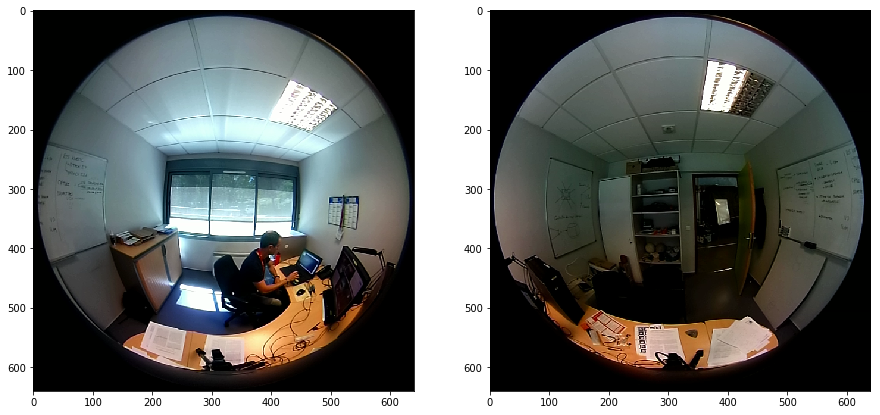

In [4]:
image_file = 'top0000.png'
image = cv2.imread(image_file)
(rows,cols,channels) = image.shape
image_size = rows
top_front_img = image[0:image_size, 0:image_size]
top_back_img  = image[0:image_size, image_size:2*image_size]
plt.subplot(121); plot(top_front_img);
plt.subplot(122); plot(top_back_img);

#### Use calibration parameters from Kalibr

In [5]:
params_file = '../../config/camchain-front_camera.yaml'
xi_f, K_f, D_f = read_ucm_params_kalibr(params_file)

In [6]:
params_file = '../../config/camchain-back_camera.yaml'
xi_b, K_b, D_b = read_ucm_params_kalibr(params_file)

### Compute rectification map and project into equirectangular image

In [7]:
map1_f, map2_f = initRectifyMap(K_f, D_f, xi_f)
map1_b, map2_b = initRectifyMap(K_b, D_b, xi_b)

In [8]:
btm_front_eqimg = equirectangular_projection(btm_front_img, map1_f, map2_f)
btm_back_eqimg = equirectangular_projection(btm_back_img, map1_b, map2_b)
btm_both_eqimg = np.concatenate((rotate_cw_90(btm_front_eqimg), rotate_cw_90(btm_back_eqimg)), axis=1)
btm_panorama = np.roll(btm_both_eqimg, 640, axis=1) # 320 + 320 (1/4 round)

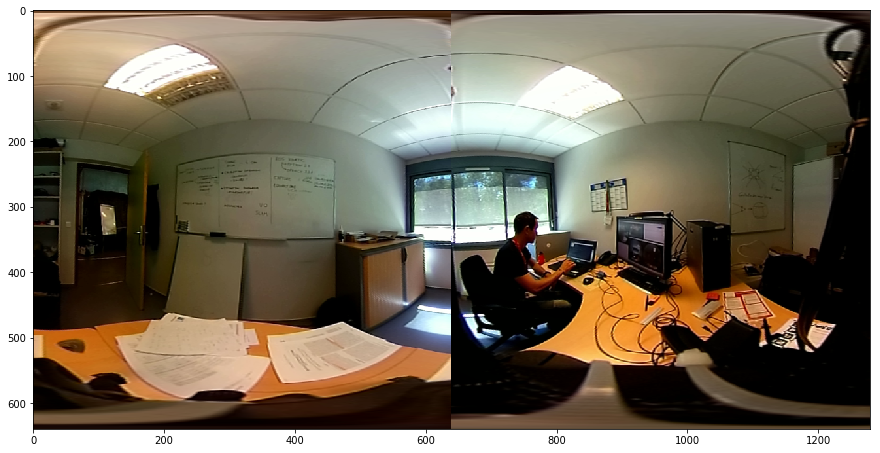

In [9]:
plot(btm_panorama);

In [10]:
top_front_eqimg = equirectangular_projection(top_front_img, map1_f, map2_f)
top_back_eqimg = equirectangular_projection(top_back_img, map1_b, map2_b)
top_both_eqimg = np.concatenate((rotate_cw_90(top_front_eqimg), rotate_cw_90(top_back_eqimg)), axis=1)
top_panorama = np.roll(top_both_eqimg, 350, axis=1) # typically 320, modified for horizontal alignment

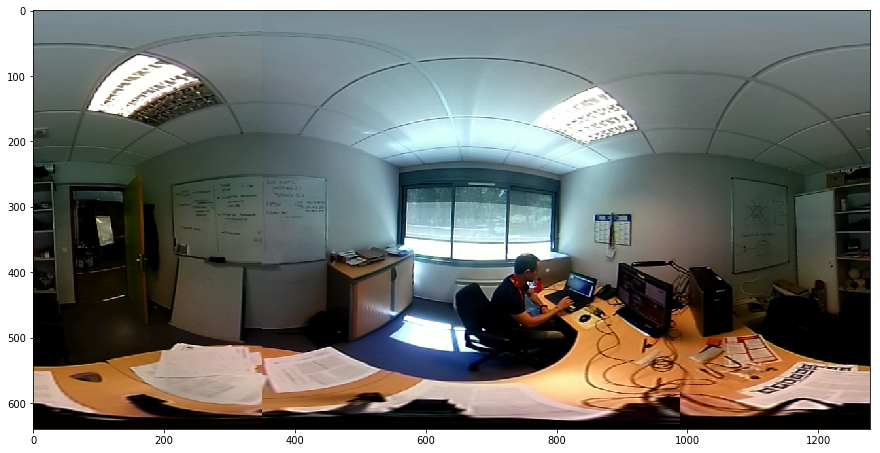

In [11]:
plot(top_panorama);

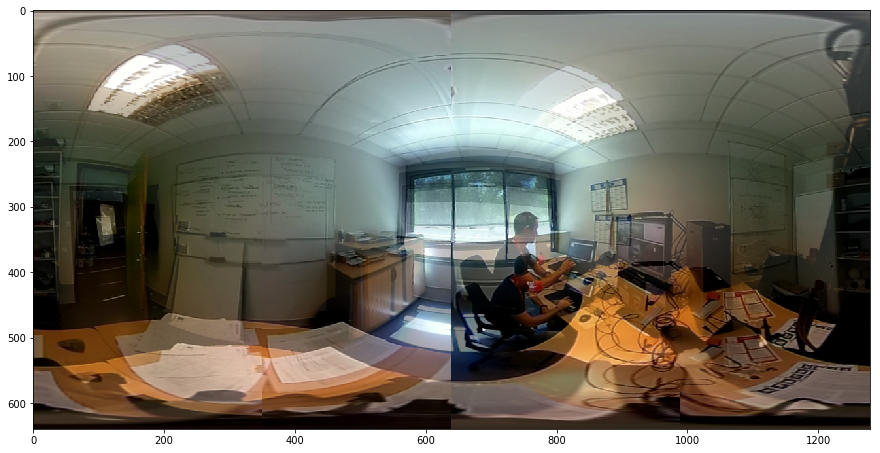

In [12]:
blended = cv2.addWeighted(btm_panorama,0.5,top_panorama,0.5,0)
plot(blended);

In [13]:
imgL = rotate_cw_90(top_panorama)
imgR = rotate_cw_90(btm_panorama)

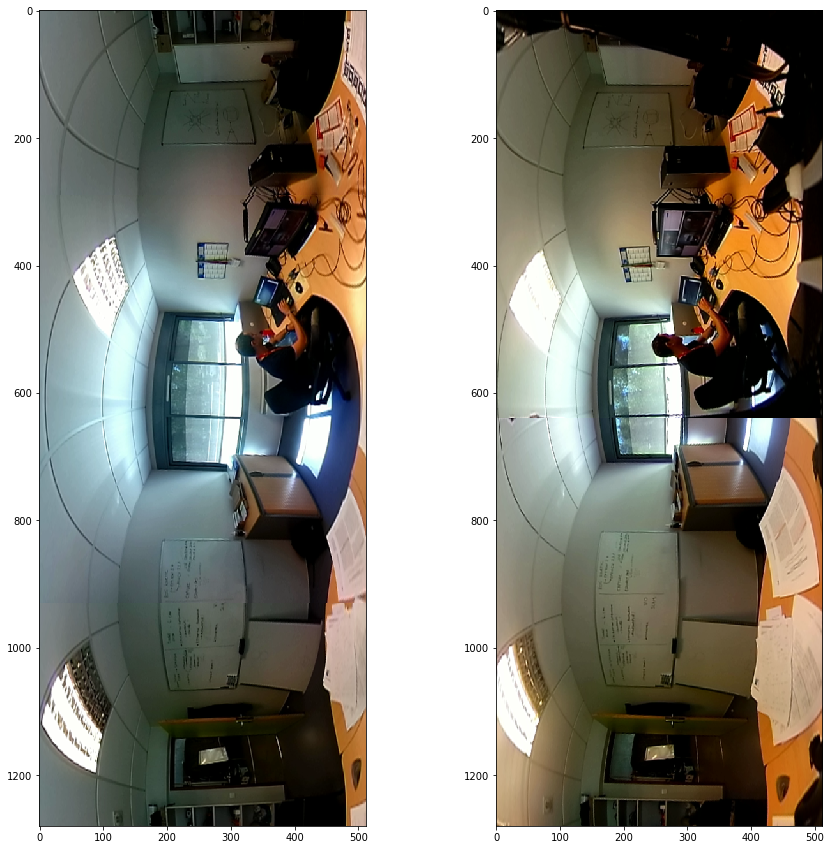

In [14]:
#plt.subplot(121); plot(imgL);
#plt.subplot(122); plot(imgR);
subimgL = imgL[:,64:576]
subimgR = imgR[:,64:576]
plt.subplot(121); plot(subimgL);
plt.subplot(122); plot(subimgR);

In [15]:
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 5,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32
)

In [16]:
disp = stereo.compute(subimgL, subimgR).astype(np.float32) / 16.0

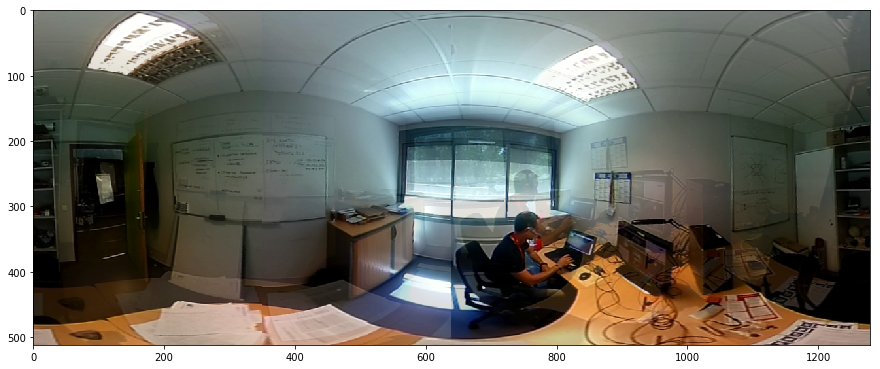

In [17]:
plot(rotate_ccw_90(cv2.addWeighted(subimgL,0.8,subimgR,0.2,0))) 

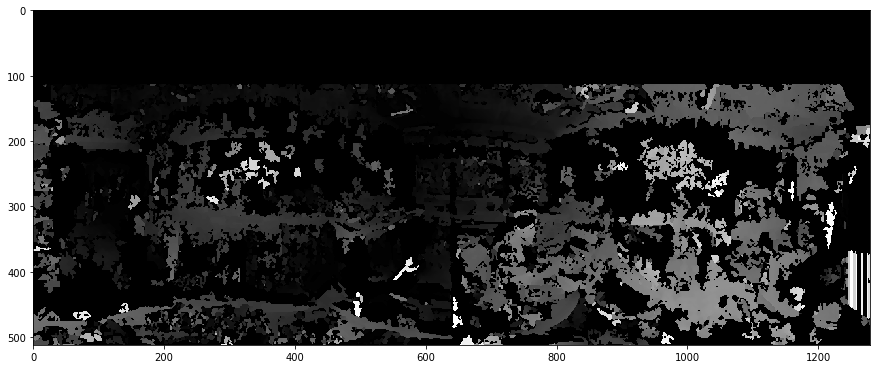

In [18]:
plt.imshow(rotate_ccw_90((disp-min_disp)/num_disp), cmap='gray');